In [1743]:
import numpy as np
import pandas as pd
from torch.autograd import Variable
data1 = pd.read_csv('SP500DATA.csv')

In [1744]:
data1['Date']

0      01/12/2021
1      01/11/2021
2      01/10/2021
3      01/09/2021
4      01/08/2021
          ...    
618    01/06/1970
619    01/05/1970
620    01/04/1970
621    01/03/1970
622    01/02/1970
Name: Date, Length: 623, dtype: object

In [1745]:
peratio = pd.read_csv('PERatio.csv')

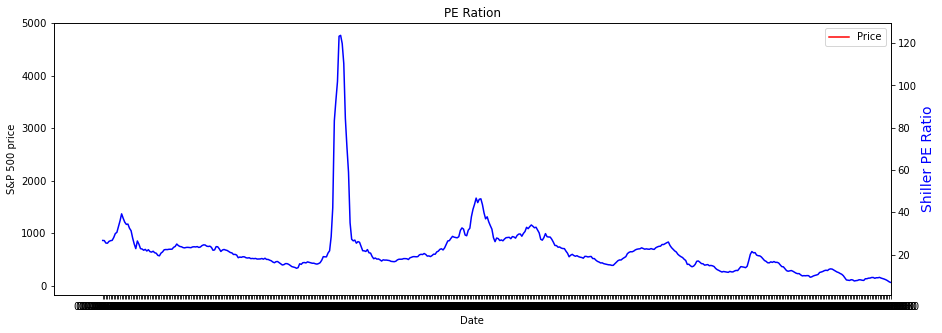

In [1746]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(data1.Date, data1.Price, color='red', label='Price')
plt.title('PE Ration')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
ax2=plt.twinx()
ax2.set_xticks(ax2.get_xticks()[::80])
plt.xlim(-31.1,500.1)
ax2.plot(peratio.DateTime, peratio.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

In [1747]:
data1

,Date,Price,Open,High,Low,Vol.,Change %
0,01/12/2021,4766.18,4623.80,4808.52,4494.20,-,0.0436
1,01/11/2021,4567.00,4616.47,4743.74,4560.26,-,-0.0083
2,01/10/2021,4605.38,4324.71,4608.70,4278.70,-,0.0691
3,01/09/2021,4307.54,4531.04,4544.58,4304.90,-,-0.0476
4,01/08/2021,4522.68,4415.90,4537.80,4369.20,-,0.0290
...,...,...,...,...,...,...,...
618,01/06/1970,72.72,76.55,79.96,72.25,-,-0.0500
619,01/05/1970,76.55,81.52,82.32,68.61,-,-0.0610
620,01/04/1970,81.52,89.63,90.70,79.31,-,-0.0905
621,01/03/1970,89.63,89.50,91.07,86.19,-,0.0015


In [1748]:
peratio = peratio.rename({'DateTime':'PE_Date','S&P 500 PE Ratio':'PE_Ratio'},axis = 1)
peratio

,PE_Date,SP500PERatio
0,01-12-2021,26.66
1,01-11-2021,26.61
2,01-10-2021,25.44
3,01-09-2021,25.35
4,01-08-2021,26.23
...,...,...
618,01-06-1970,13.69
619,01-05-1970,13.69
620,01-04-1970,15.37
621,01-03-1970,15.75


In [1749]:
spdata = data1[['Price','Open']].to_numpy(dtype = 'float')

outdata = data1[["Price"]].to_numpy(dtype = 'float')

In [1750]:
date = data1[['Date']].to_numpy(dtype = "str")
date = np.flip(date)
dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [1721]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler(feature_range = (0,1))
spdata = mmscaler.fit_transform(spdata)
outdata = mmscaler.fit_transform(outdata)
spdata = np.flip(spdata)
outdata = np.flip(outdata)

In [1722]:
outdata.shape

(623, 1)

In [1723]:
rows,cols = spdata.shape

In [1724]:
inputsize = 2
outputsize = 4
window = 6

In [1075]:
X = []
y=[]
for i in range(rows-window-outputsize+1):
    X.append(spdata[i:i+window])
    y.append(spdata[i+window:i+window+outputsize,0])
X,y = np.array(X),np.array(y)
y = np.reshape(y,(y.shape[0],1,y.shape[1]))

In [1076]:
X.shape

(614, 6, 2)

In [1077]:
y.shape

(614, 1, 4)

training and testing datasets created.... !!!!

In [1078]:
from sklearn.model_selection import train_test_split
X_full_train = []
X_train = []
X_validation = []
X_test = []
y_full_train = []
y_train = []
y_validation= []
y_test=[]

X_full_train, X_test, y_full_train, y_test, date_ft, date_t = train_test_split(X,y,dateAxis,test_size = 0.3, shuffle = False)
X_train, X_validation, y_train, y_validation, date_tr, date_v = train_test_split(X_full_train, y_full_train,date_ft,test_size = 0.3, shuffle = False)
date_test = date[438:623,:]

In [1416]:
X_train.shape

(300, 6, 2)

In [1361]:
X_train.tofile('trainingset.csv', sep = ',')


In [1080]:
X_validation.shape

(129, 6, 2)

In [1363]:
X_validation.tofile('validationset.csv', sep = ',')



In [1081]:
X_test.shape

(185, 6, 2)

In [1362]:
X_test.tofile('testingset.csv', sep = ',')



In [1351]:
X_test.tofile('XTest.csv', sep = ',')

In [1082]:
y_train.shape

(300, 1, 4)

# Step - 2

In [1083]:
import torch
import torch.nn as nn
from torch.autograd import Variable
class Model(nn.Module):
    def __init__(self, input_size, output_size,hidden_dim, n_layers):
        super(Model,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size,hidden_dim,n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out,hidden = self.rnn(x,hidden)
        out = self.fc(out)
        return out[:,-1,:], hidden
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers,batch_size,self.hidden_dim)
        return hidden

In [1373]:
RNN = Model(input_size = 2, output_size = 4, hidden_dim = 16, n_layers =1)
optimizer = torch.optim.Adam(RNN.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [1374]:
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# STEP - 3

In [1375]:

xTensor = torch.from_numpy(X_full_train).float()
yTensor = torch.Tensor(y_full_train).float()
tot_loss = []
for epoch in range(100):
    
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    tot_loss +=[loss.item()]
    loss.backward()
    #add validation code
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}------'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100------ Loss: 0.11068230867385864
Epoch: 10/100------ Loss: 0.06086317077279091
Epoch: 20/100------ Loss: 0.03634512796998024
Epoch: 30/100------ Loss: 0.02244562841951847
Epoch: 40/100------ Loss: 0.014722288586199284
Epoch: 50/100------ Loss: 0.01085607334971428
Epoch: 60/100------ Loss: 0.009068229235708714
Epoch: 70/100------ Loss: 0.008410017006099224
Epoch: 80/100------ Loss: 0.008133760653436184
Epoch: 90/100------ Loss: 0.007868124172091484


In [1087]:
def pred_error(pred,actual):
    return abs(pred-actual)/pred

In [1088]:
output.shape

torch.Size([429, 4])

In [1089]:
hidden.shape

torch.Size([1, 429, 16])

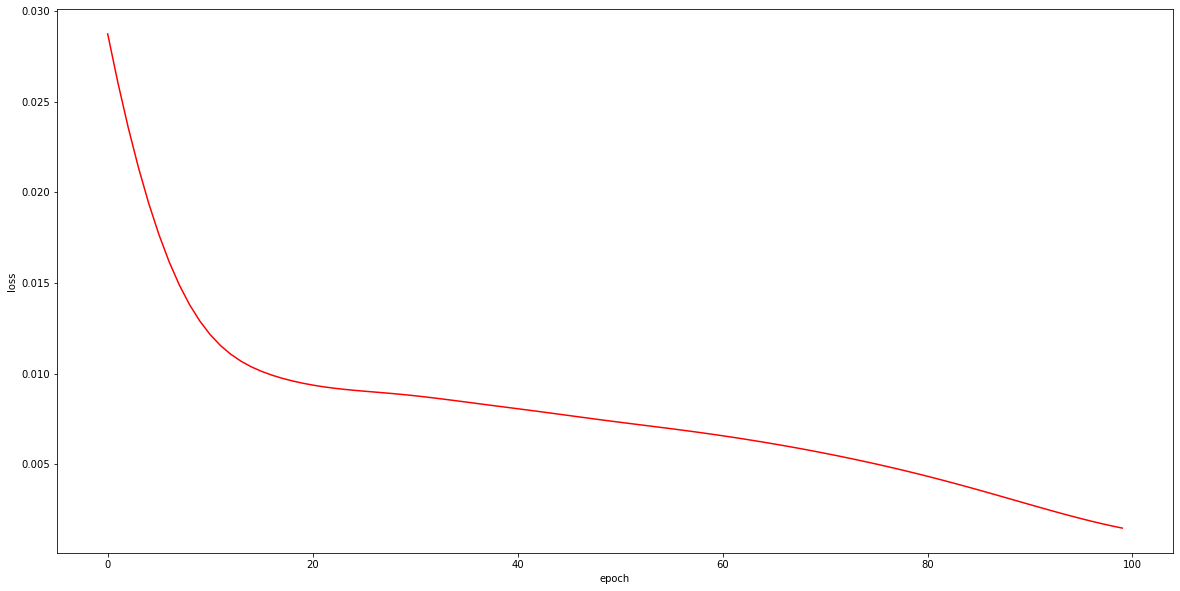

In [1090]:
plt.figure(figsize = [20,10])
plt.plot(np.array(tot_loss),'r',label = 'train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [1378]:
out1 = output.detach().numpy()[:,0]
out1 = mmscaler.inverse_transform(out1.reshape(-1,1))
out2 = output.detach().numpy()[:,1]
out2 = mmscaler.inverse_transform(out2.reshape(-1,1))
out3 = output.detach().numpy()[:,2]
out3 = mmscaler.inverse_transform(out3.reshape(-1,1))
out4 = output.detach().numpy()[:,3]
out4 = mmscaler.inverse_transform(out4.reshape(-1,1))

In [1379]:
out1.shape

(429, 1)

In [1380]:
y_plt = mmscaler.inverse_transform(y[:,:,0])
y_train_plt = mmscaler.inverse_transform(y_full_train[:,:,0])

In [1381]:
error = pred_error(out1, y_train_plt)

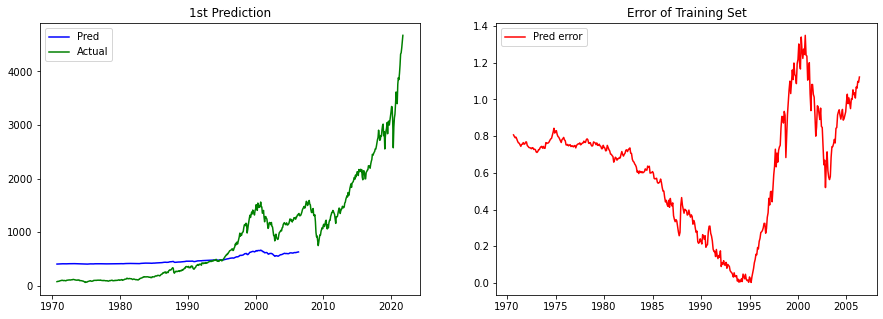

In [1382]:
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("1st Prediction")
ax1.plot(date_ft, out1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


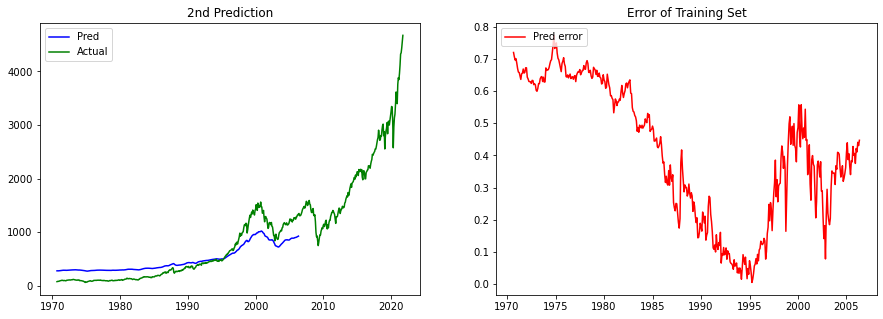

In [1096]:
error = pred_error(out2, y_train_plt)
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("2nd Prediction")
ax1.plot(date_ft, out2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



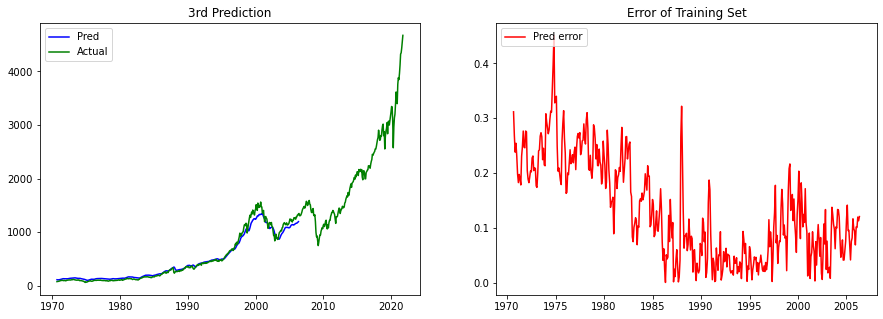

In [1097]:
error = pred_error(out3, y_train_plt)
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("3rd Prediction")
ax1.plot(date_ft, out3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

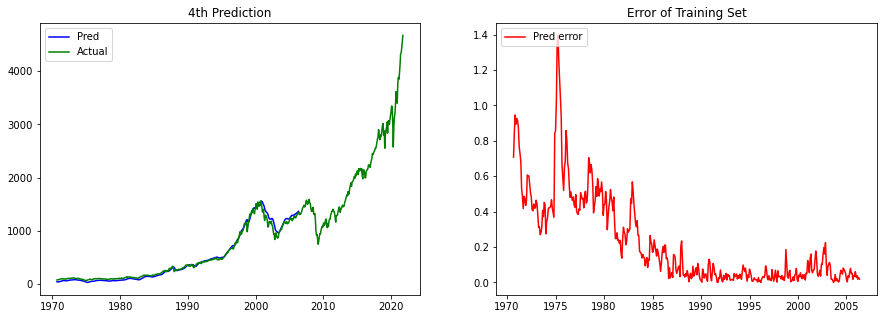

In [1098]:
error = pred_error(out4, y_train_plt)
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("4th Prediction")
ax1.plot(date_ft, out4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

# step 4

In [1099]:
RNN.eval()

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [1100]:
xTensor = torch.from_numpy(X_test).float()
output,_ = RNN(torch.from_numpy(X_test).float())




In [1101]:
output.shape

torch.Size([185, 4])

In [1102]:
out1 = output.detach().numpy()[:,0]
out1 = mmscaler.inverse_transform(out1.reshape(-1,1))
out2 = output.detach().numpy()[:,1]
out2 = mmscaler.inverse_transform(out2.reshape(-1,1))
out3 = output.detach().numpy()[:,2]
out3 = mmscaler.inverse_transform(out3.reshape(-1,1))
out4 = output.detach().numpy()[:,3]
out4 = mmscaler.inverse_transform(out4.reshape(-1,1))

In [1383]:
y_plt.shape

(614, 1)

In [1106]:
y_test_plt = mmscaler.inverse_transform(y_test[:,:,0])

In [1107]:
y_test_plt.shape

(185, 1)

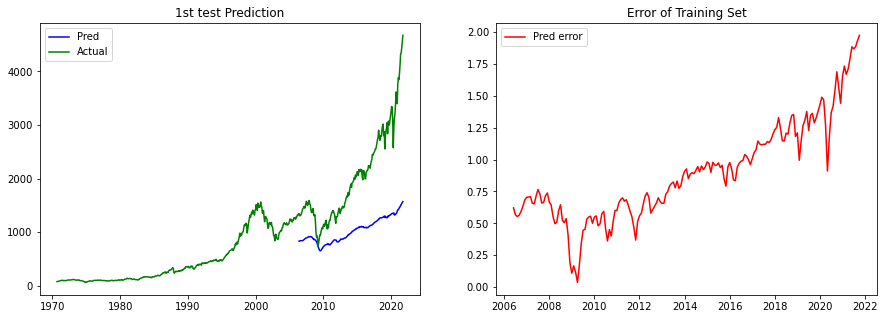

In [1108]:
error = pred_error(out1, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("1st test Prediction")
ax1.plot(date_t, out1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



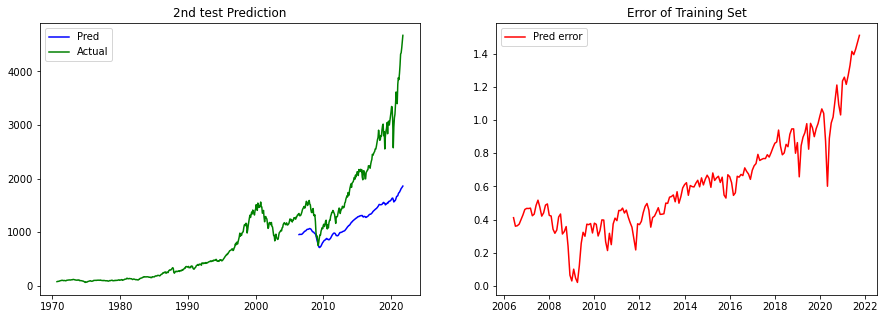

In [1109]:
error = pred_error(out2, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("2nd test Prediction")
ax1.plot(date_t, out2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



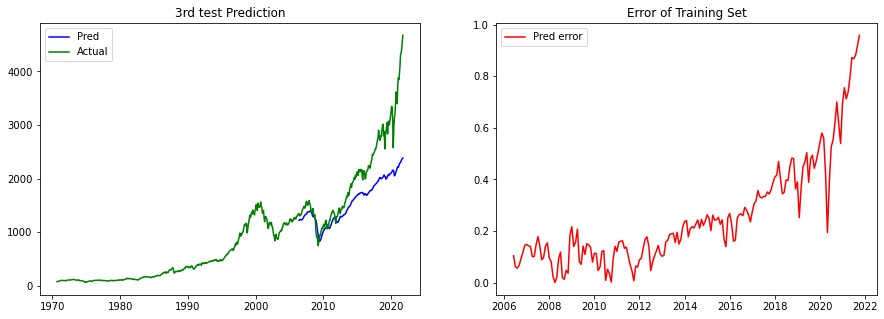

In [1110]:
error = pred_error(out3, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("3rd test Prediction")
ax1.plot(date_t, out3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



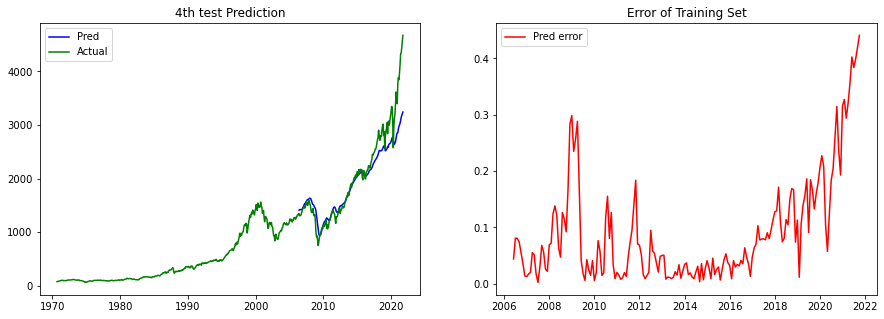

In [1111]:
error = pred_error(out4, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("4th test Prediction")
ax1.plot(date_t, out4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



# Step - 5

## New Model - optimized to get better output

In [1112]:
RNN = Model(input_size = 2, output_size = 4, hidden_dim = 64, n_layers =2)
optimizer = torch.optim.Adam(RNN.parameters(), lr = 0.002)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [1113]:

xTensor = torch.from_numpy(X_train).float()
yTensor = torch.Tensor(y_train).float()
tot_loss = []
for epoch in range(100):
    
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    tot_loss +=[loss.item()]
    loss.backward()
    #add validation code
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.0026334680151194334
Epoch: 10/100............. Loss: 0.0010996550554409623
Epoch: 20/100............. Loss: 0.0008058804087340832
Epoch: 30/100............. Loss: 0.0003935045388061553
Epoch: 40/100............. Loss: 0.00013661320554092526
Epoch: 50/100............. Loss: 4.4908400013810024e-05
Epoch: 60/100............. Loss: 1.909602178784553e-05
Epoch: 70/100............. Loss: 1.82527528522769e-05
Epoch: 80/100............. Loss: 3.034695328096859e-05
Epoch: 90/100............. Loss: 2.69313659373438e-05


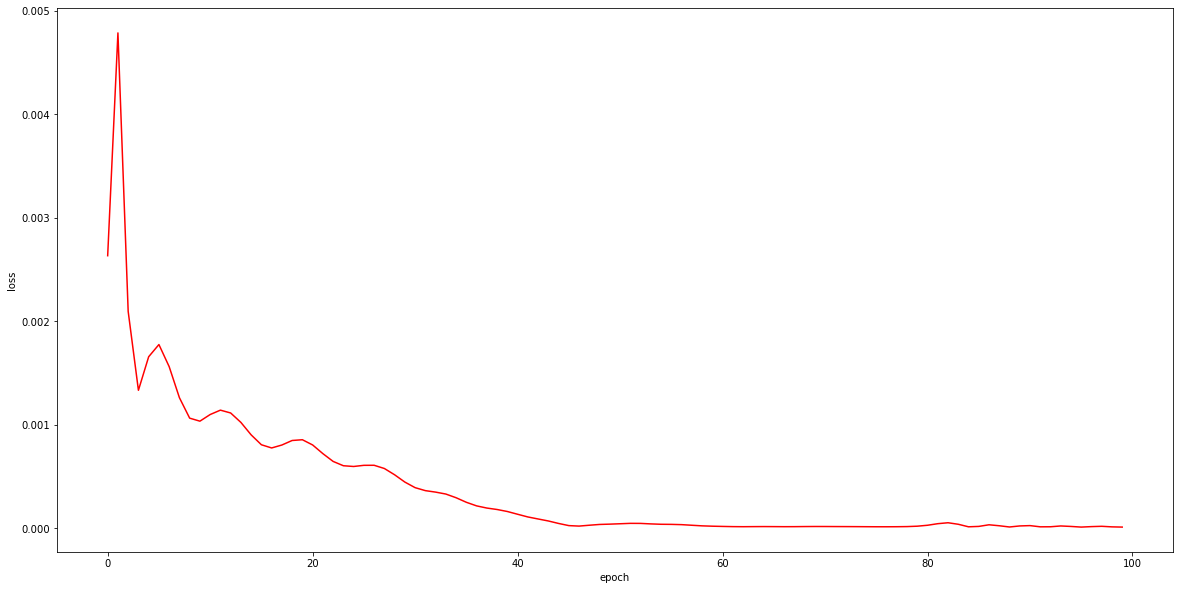

In [1114]:
plt.figure(figsize = [20,10])
plt.plot(np.array(tot_loss),'r',label = 'train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [1115]:
out1 = output.detach().numpy()[:,0]
out1 = mmscaler.inverse_transform(out1.reshape(-1,1))
out2 = output.detach().numpy()[:,1]
out2 = mmscaler.inverse_transform(out2.reshape(-1,1))
out3 = output.detach().numpy()[:,2]
out3 = mmscaler.inverse_transform(out3.reshape(-1,1))
out4 = output.detach().numpy()[:,3]
out4 = mmscaler.inverse_transform(out4.reshape(-1,1))

In [1116]:
y_plt = mmscaler.inverse_transform(y[:,:,0])
y_train_plt = mmscaler.inverse_transform(y_train[:,:,0])

In [1117]:
out1.shape

(300, 1)

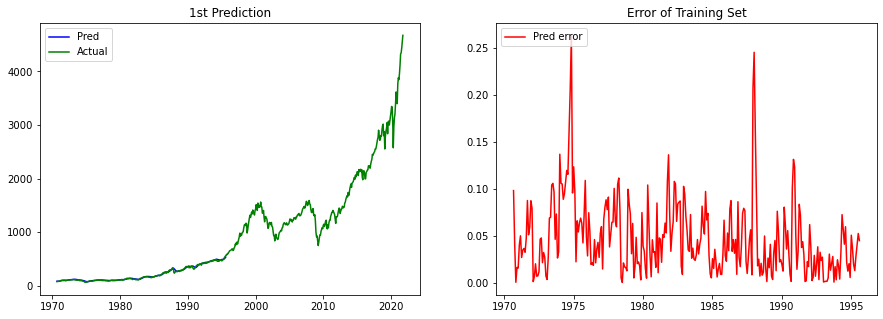

In [1118]:
error = pred_error(out1, y_train_plt)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("1st Prediction")
ax1.plot(date_tr, out1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



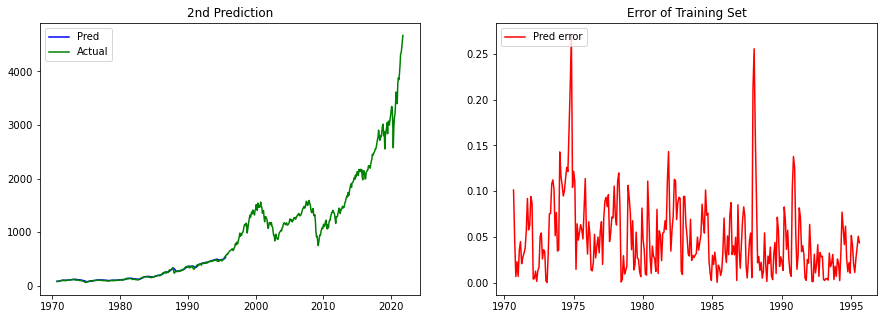

In [1119]:
error = pred_error(out2, y_train_plt)
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("2nd Prediction")
ax1.plot(date_tr, out2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")



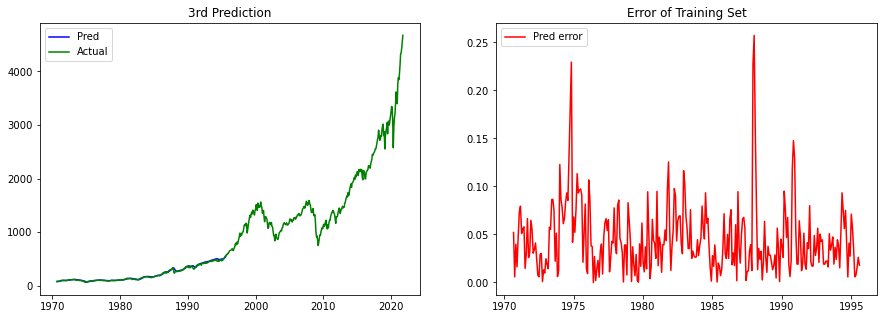

In [1120]:
error = pred_error(out3, y_train_plt)
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("3rd Prediction")
ax1.plot(date_tr, out3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

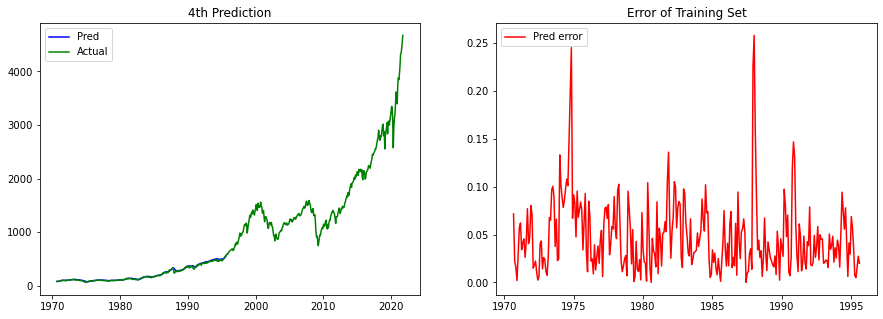

In [1121]:
error = pred_error(out4, y_train_plt)
error_data = pd.DataFrame(data = error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("4th Prediction")
ax1.plot(date_tr, out4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

# Now testing

In [1148]:
RNN.eval()

Model(
  (rnn): RNN(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [1149]:
xTensor = torch.from_numpy(X_validation).float()
output,_ = RNN(torch.from_numpy(X_validation).float())
output.shape

torch.Size([129, 4])

In [1150]:
out1 = output.detach().numpy()[:,0]
out1 = mmscaler.inverse_transform(out1.reshape(-1,1))
out2 = output.detach().numpy()[:,1]
out2 = mmscaler.inverse_transform(out2.reshape(-1,1))
out3 = output.detach().numpy()[:,2]
out3 = mmscaler.inverse_transform(out3.reshape(-1,1))
out4 = output.detach().numpy()[:,3]
out4 = mmscaler.inverse_transform(out4.reshape(-1,1))

In [1151]:
out1.shape

(129, 1)

In [1152]:
y_test_plt = mmscaler.inverse_transform(y_validation[:,:,0])

In [1153]:
y_test_plt.shape

(129, 1)

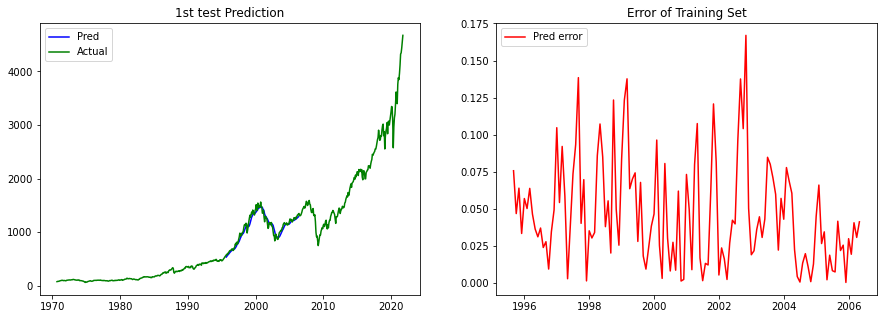

In [1154]:
error = pred_error(out1, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("1st test Prediction")
ax1.plot(date_v, out1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")




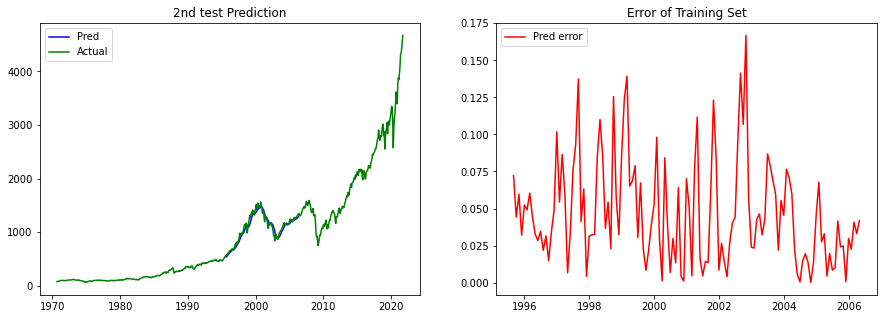

In [1155]:
error = pred_error(out2, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("2nd test Prediction")
ax1.plot(date_v, out2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")





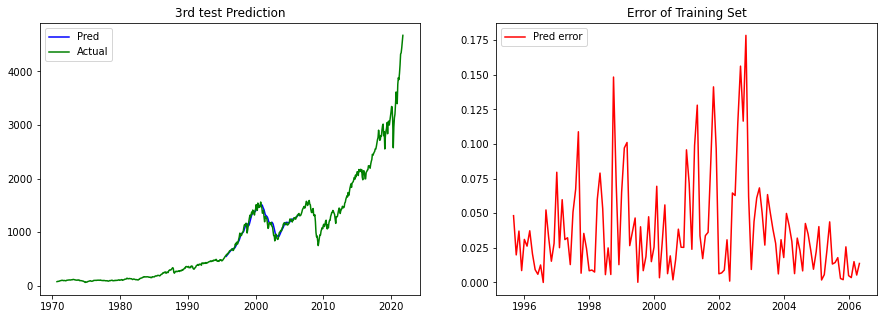

In [1156]:
error = pred_error(out3, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("3rd test Prediction")
ax1.plot(date_v, out3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")





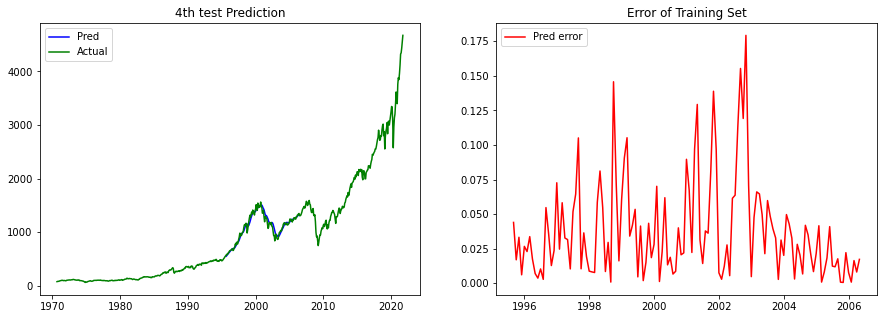

In [1157]:
error = pred_error(out4, y_test_plt)
error_data = pd.DataFrame(data = error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("4th test Prediction")
ax1.plot(date_v, out4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")





# Step 6

In [1158]:
import random


stdDevs = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def perturb(dataset,std_dev):
    NoisyData = np.ndarray(shape = dataset.shape,dtype=np.float32)
    
    for i in range(6):
        sampledata = np.random.normal(0,std_dev,20)
        index = random.sample(list(range(180)),20)
        NoisyData[i] = dataset[i]
        NoisyData[index, i,0] = NoisyData[index,i,0]+sampledata
    return NoisyData
        

In [1159]:
def prediction(index):
    output = np.concatenate( (y_test[:, :, index], y_test[:, :, index], y_test[:, :, index]), axis = 1)
    desired = mmscaler.inverse_transform(output)[:,[0]]
    tot_error = []
    for std in stdDevs:
        noisydata = perturb(X_test,std)
        inputs = Variable(torch.from_numpy(noisydata).float())
        output,_ = RNN(inputs)
        output = np.concatenate((output.detach().numpy()[:,[index]],
                                output.detach().numpy()[:,[index]],
                                output.detach().numpy()[:,[index]]),axis = 1)
        prediction = mmscaler.inverse_transform(output)[:,[0]]
        error = pred_error(desired, prediction)
        tot_error.append(error.reshape(-1))
    return tot_error
        


In [1385]:
error_res_all=prediction(0)
labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdDevs).T
display(df_error)


,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.527820,0.527802,0.527802,0.527802,0.527802,0.527907,0.527802,0.527802,0.527802
01/09/2006,0.515242,0.515223,0.515242,0.515242,0.515471,0.516309,0.512707,0.515242,0.515242
01/10/2006,0.516862,0.516862,0.516862,0.516862,0.516862,0.516862,0.516862,0.516862,0.539952
01/11/2006,0.520675,0.520675,0.520675,0.520675,0.520675,0.520675,0.520675,0.520791,0.530542
01/12/2006,0.527792,0.527770,0.527745,0.527562,0.527119,0.527562,0.527562,0.527562,0.527562
...,...,...,...,...,...,...,...,...,...
01/08/2021,0.787081,0.492172,0.906491,0.517942,0.661051,0.906491,1.538505,1.181021,1.029560
01/09/2021,0.988778,0.495129,0.907036,1.535369,1.223866,0.907036,1.535369,0.789215,0.783269
01/10/2021,0.792630,0.505406,0.908928,1.524471,1.219309,0.908928,1.524471,1.275391,0.407565
01/11/2021,0.911235,1.511187,0.911235,0.545307,NaN,0.911235,0.570132,1.268415,0.422571


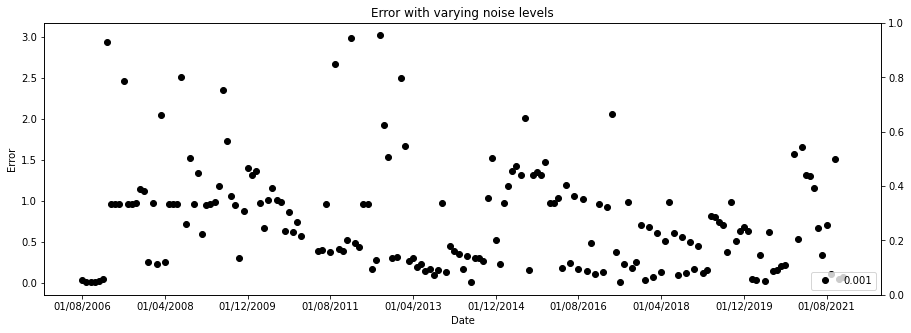

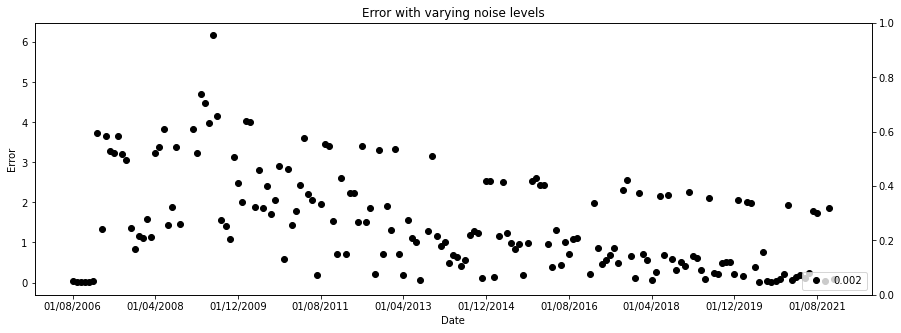

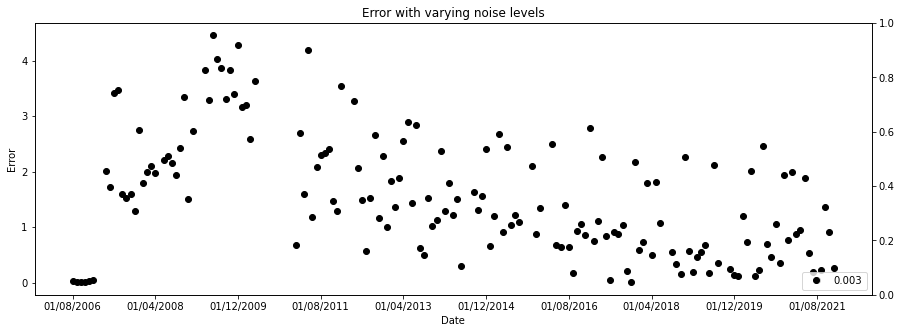

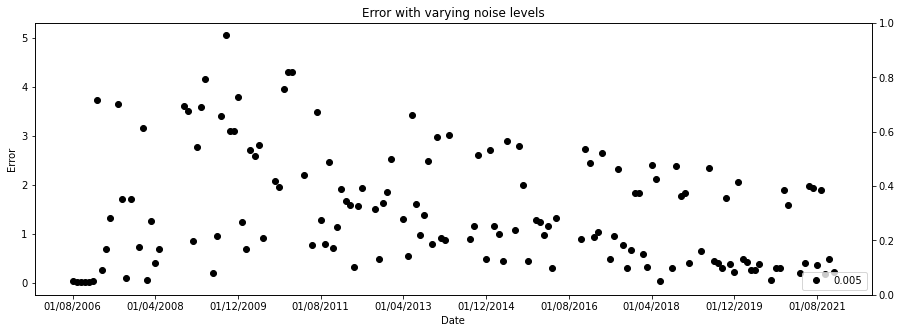

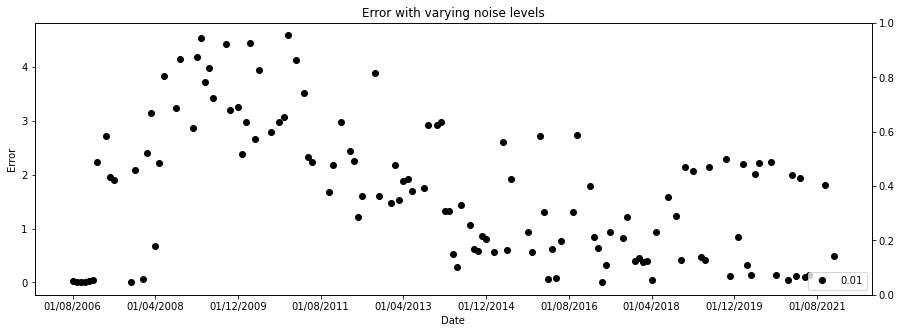

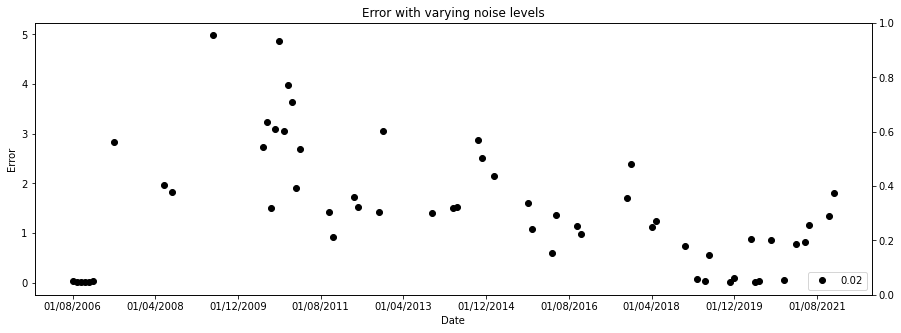

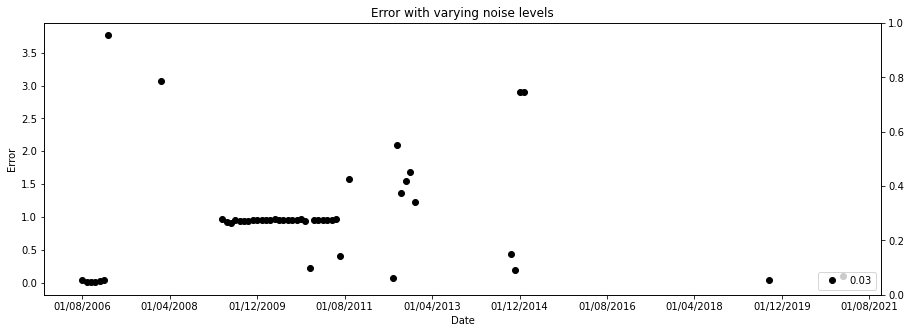

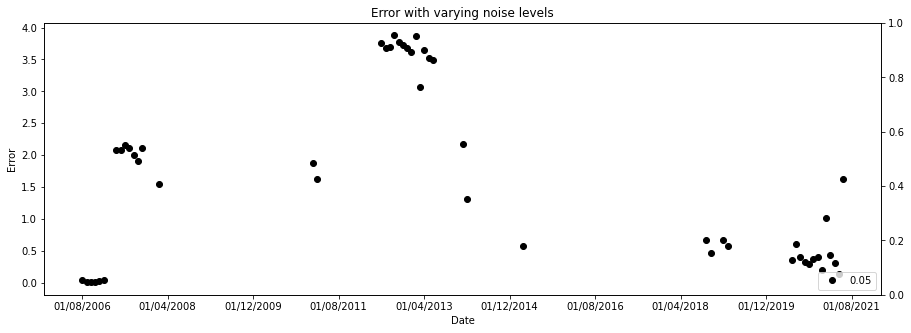

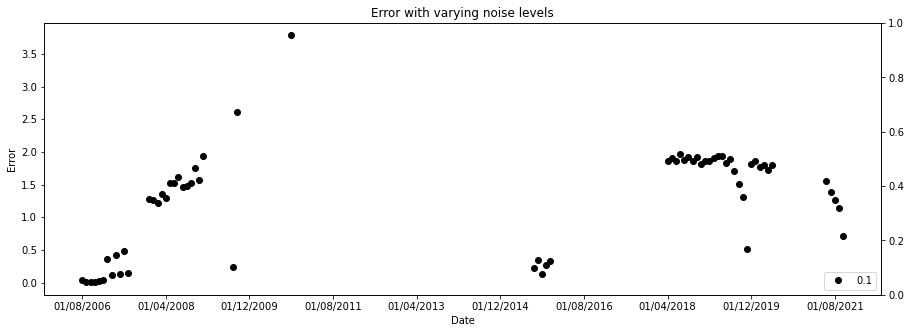

In [1161]:
for i in range(len(stdDevs)):
    plt.figure(1, figsize=(15, 5))
    plt.plot(np.squeeze(date_test),error_res_all[i], color = 'black',lw = 1, label = stdDevs[i],marker = 'o',linestyle = 'None')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.title('Error with varying noise levels')
    plt.legend(loc="lower right")
    ax2=plt.twinx()
    ax2.set_xticks(ax2.get_xticks()[::20])
    plt.show()
    


,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.004472,0.004514,0.004926,0.004472,0.004472,0.004472,0.004472,0.004472,0.044075
01/09/2006,0.001753,0.001753,0.002203,0.001841,0.001753,0.001753,0.018410,0.001753,0.001753
01/10/2006,0.002746,0.003153,0.003774,0.002746,0.008910,0.002746,0.004786,0.022156,0.002746
01/11/2006,0.023219,0.023219,0.023219,0.024113,0.023219,0.023219,0.023219,0.023219,0.023219
01/12/2006,0.045888,0.045888,0.045888,0.045888,0.045888,0.048218,0.045888,0.045888,0.045888
...,...,...,...,...,...,...,...,...,...
01/08/2021,1.548768,1.389852,0.244539,0.898387,1.489225,0.188135,0.429163,0.818361,NaN
01/09/2021,0.536231,0.209553,0.322134,NaN,NaN,0.597145,0.730128,0.253252,NaN
01/10/2021,0.296895,1.602632,0.143407,NaN,1.212407,0.454853,1.246343,0.706876,NaN
01/11/2021,0.178859,1.169809,1.123847,0.588447,0.914778,1.589303,1.612292,NaN,NaN


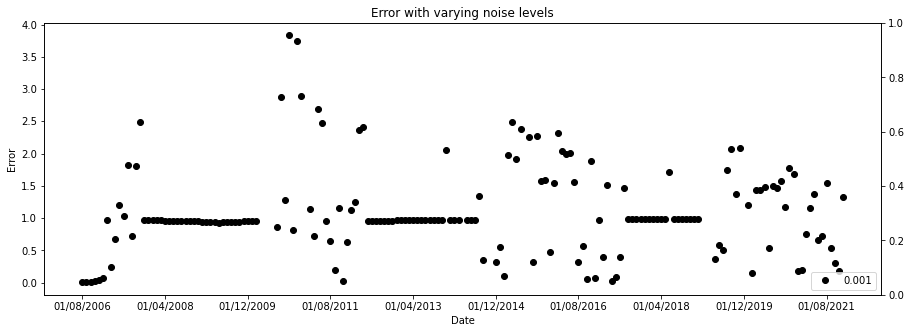

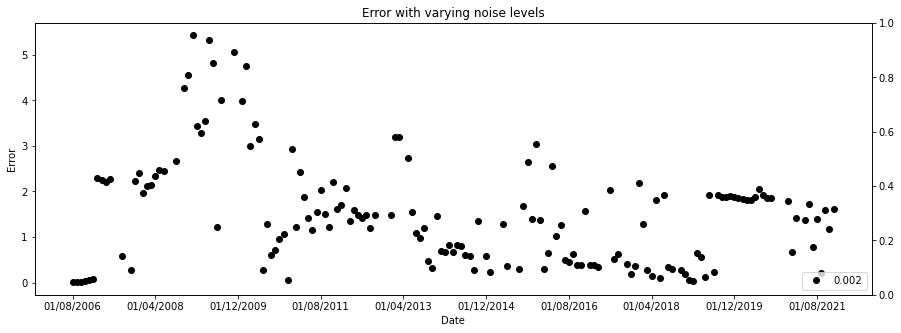

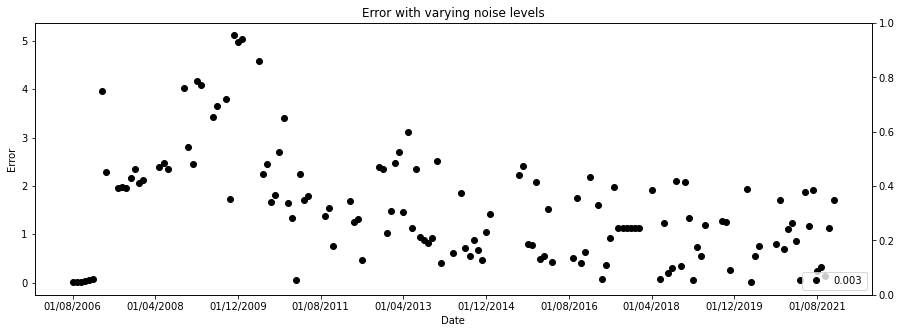

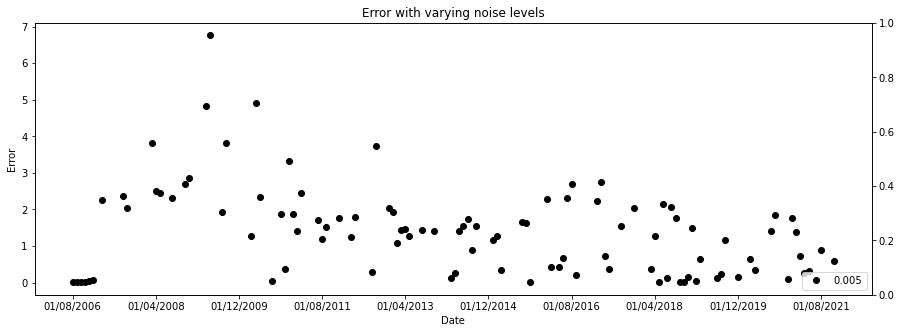

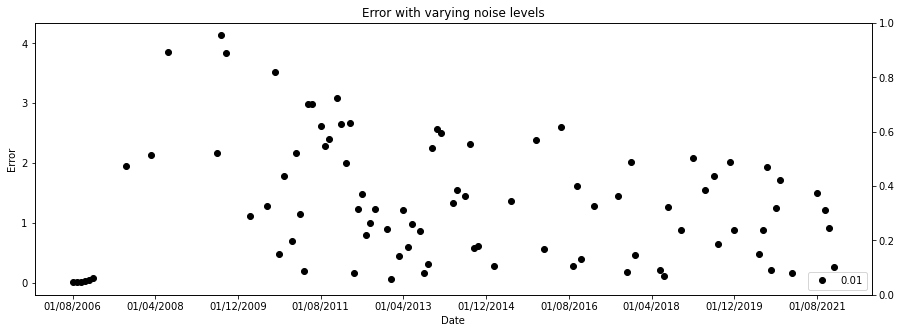

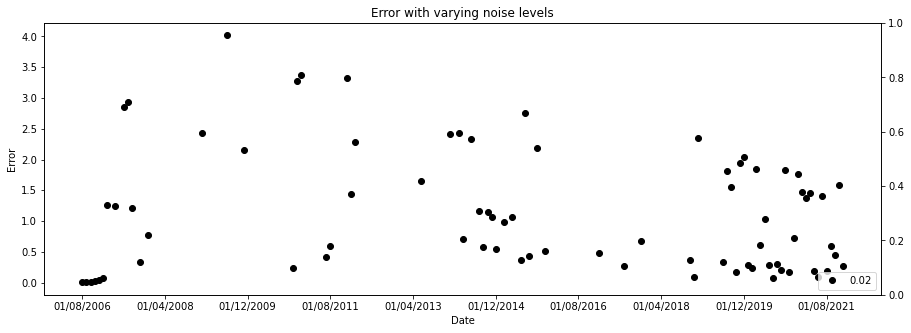

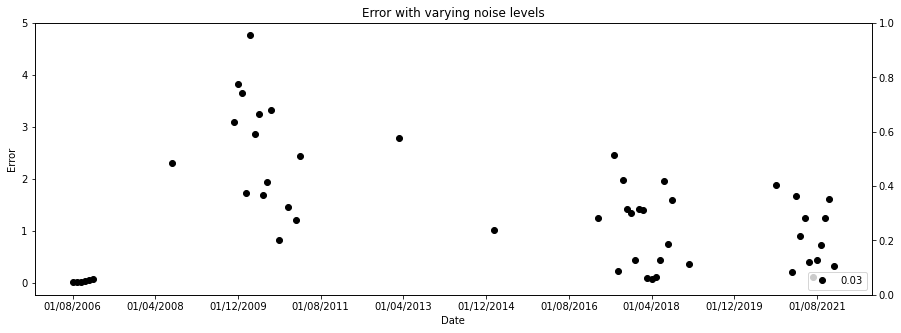

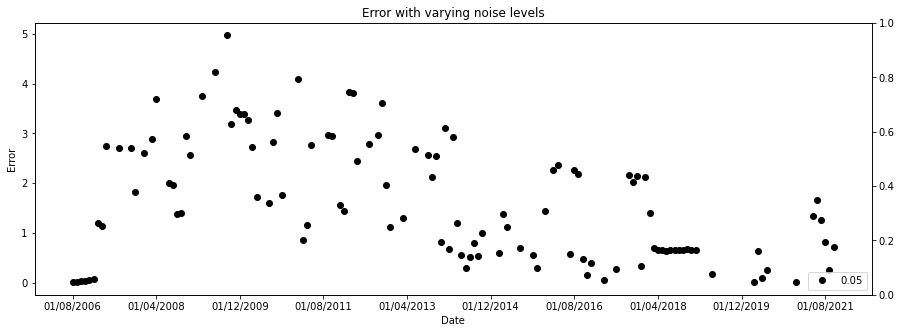

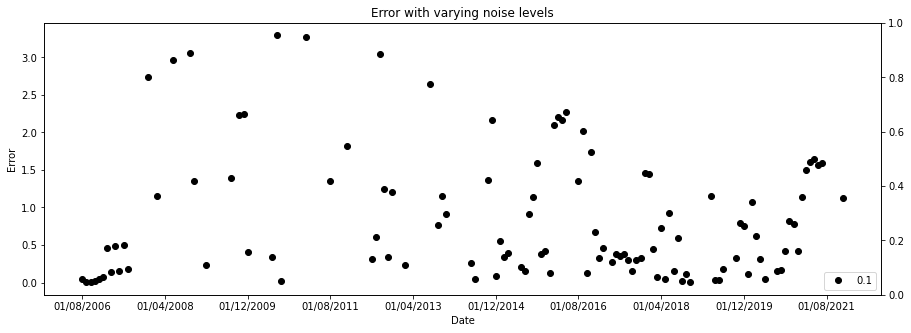

In [1162]:
error_res_all=prediction(1)
labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdDevs).T
display(df_error)
for i in range(len(stdDevs)):
    plt.figure(1, figsize=(15, 5))
    plt.plot(np.squeeze(date_test),error_res_all[i], color = 'black',lw = 1, label = stdDevs[i],marker = 'o',linestyle = 'None')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.title('Error with varying noise levels')
    plt.legend(loc="lower right")
    ax2=plt.twinx()
    ax2.set_xticks(ax2.get_xticks()[::20])
    plt.show()

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.023061,0.023192,0.022647,0.023039,0.023192,0.016632,0.023192,0.027596,0.023192
01/09/2006,0.023440,0.023440,0.023440,0.023329,0.023440,0.023440,0.019259,0.027993,0.023440
01/10/2006,0.002743,0.002776,0.002407,0.000780,0.004106,0.002776,0.002776,0.002776,0.002776
01/11/2006,0.022544,0.022544,0.023613,0.022544,0.022544,0.039987,0.025415,0.021687,0.006229
01/12/2006,0.052604,0.052604,0.051663,0.052604,0.047687,0.052604,0.050519,0.052604,0.052604
...,...,...,...,...,...,...,...,...,...
01/08/2021,0.115247,0.162563,0.988078,0.096222,0.097747,0.459533,0.385490,0.096222,0.385490
01/09/2021,0.048806,0.234015,0.988404,1.701201,1.662224,0.273145,0.282847,1.701201,0.282847
01/10/2021,0.061988,0.251053,0.988675,0.073625,1.645313,0.963723,0.416281,0.073625,0.416281
01/11/2021,0.312282,0.227877,0.988145,0.099100,0.096921,0.382871,0.313899,0.099100,0.313899


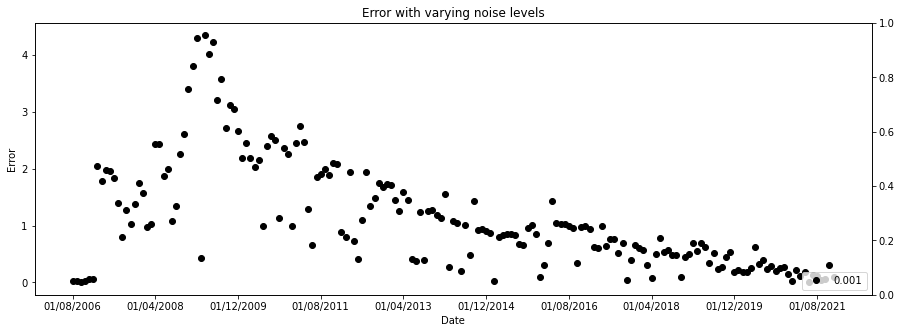

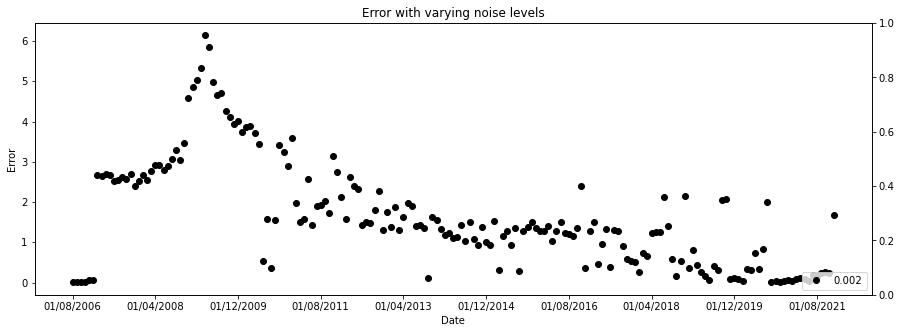

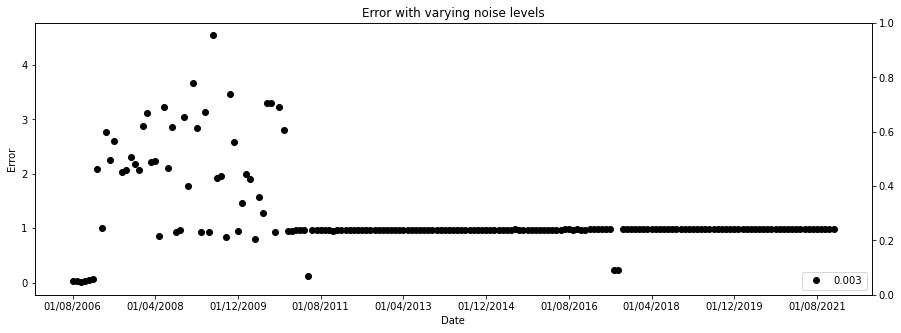

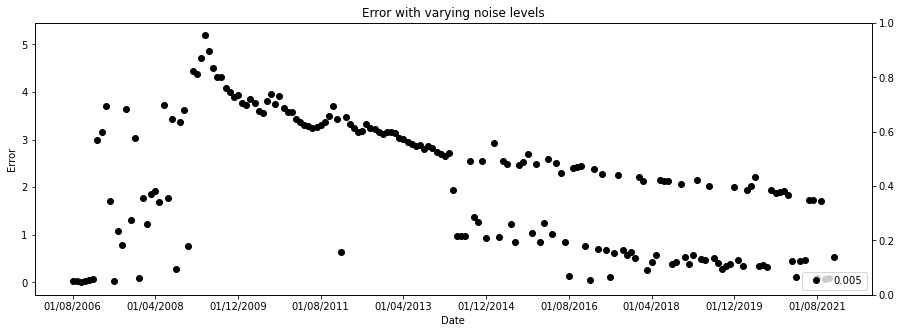

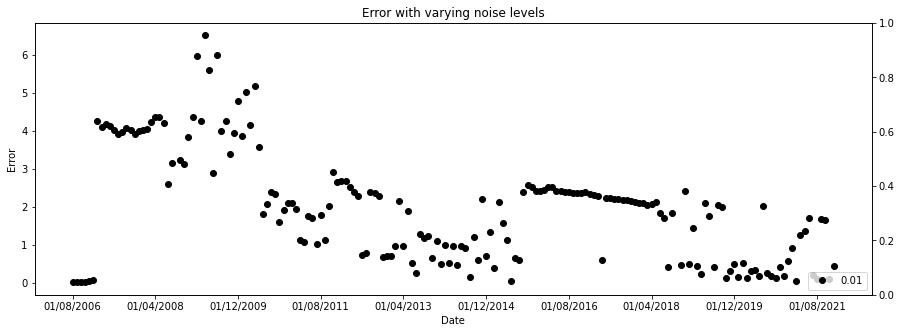

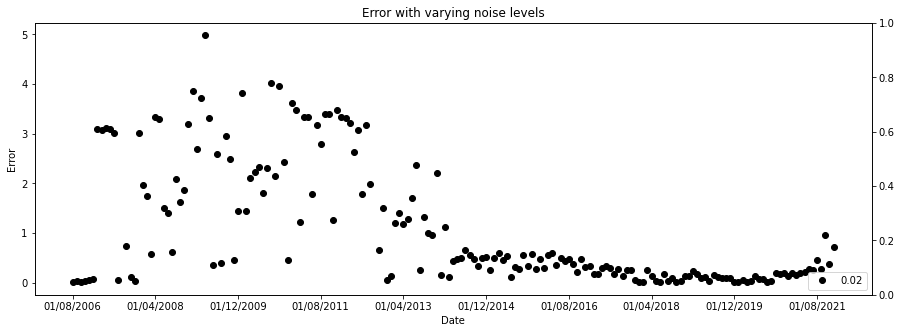

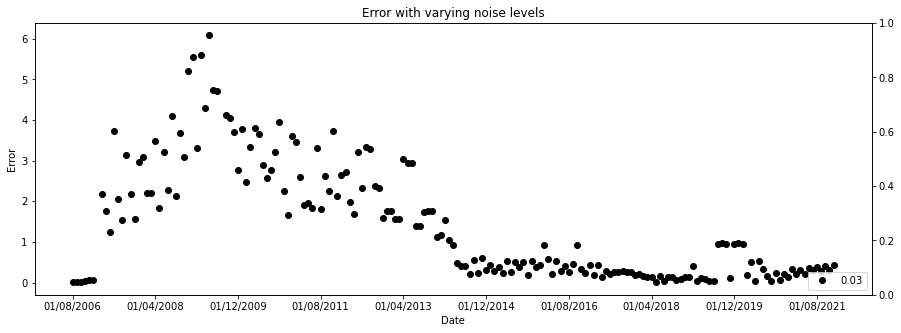

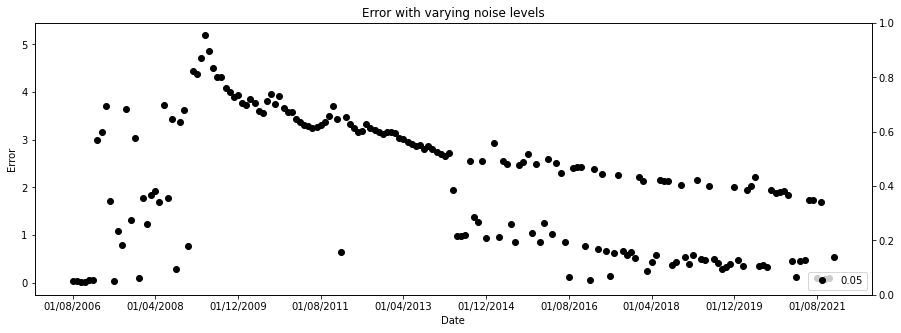

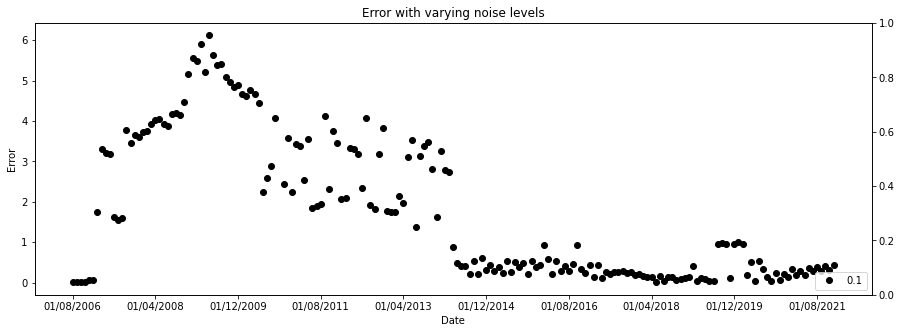

In [1163]:
error_res_all=prediction(2)
labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdDevs).T
display(df_error)
for i in range(len(stdDevs)):
    plt.figure(1, figsize=(15, 5))
    plt.plot(np.squeeze(date_test),error_res_all[i], color = 'black',lw = 1, label = stdDevs[i],marker = 'o',linestyle = 'None')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.title('Error with varying noise levels')
    plt.legend(loc="lower right")
    ax2=plt.twinx()
    ax2.set_xticks(ax2.get_xticks()[::20])
    plt.show()

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.012586,0.012809,0.012809,0.013356,0.005484,0.012809,0.012809,0.000102,0.012809
01/09/2006,0.000550,0.000086,0.000550,0.000550,0.000550,0.007650,0.010203,0.005362,0.005345
01/10/2006,0.024234,0.024234,0.024234,0.020100,0.022805,0.024234,0.017473,0.024234,0.049082
01/11/2006,0.056129,0.056129,0.056907,0.055130,0.056129,0.056129,0.052251,0.036571,0.058834
01/12/2006,0.070131,0.069947,0.070131,0.068423,0.065692,0.070131,0.070131,0.070131,0.070131
...,...,...,...,...,...,...,...,...,...
01/08/2021,0.987555,1.419481,1.554817,1.387599,1.815465,0.987538,0.251050,1.862781,0.987538
01/09/2021,0.987871,1.408094,1.262286,0.208942,1.717881,0.987871,1.277250,1.771434,0.987871
01/10/2021,0.987292,1.428339,1.769229,0.664880,0.320280,0.987320,0.185953,1.743756,0.987320
01/11/2021,0.988096,1.400539,1.644310,1.645477,0.093531,1.433234,1.846531,1.682416,1.433234


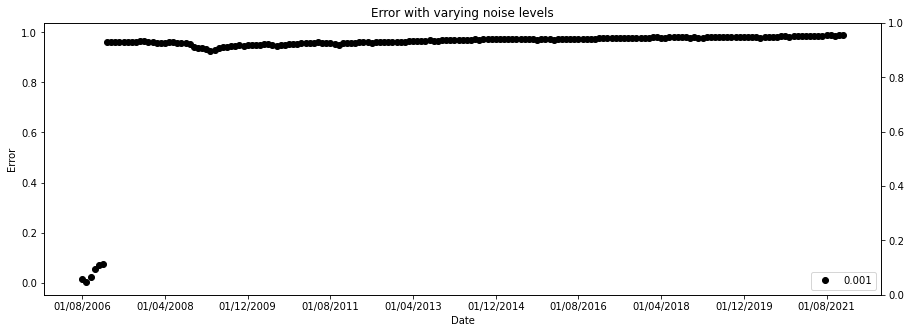

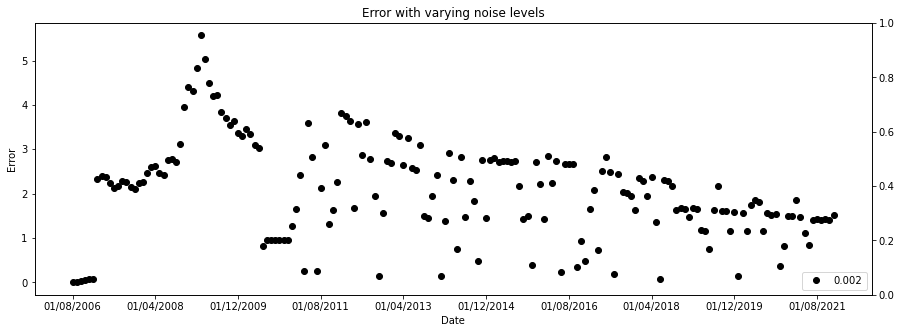

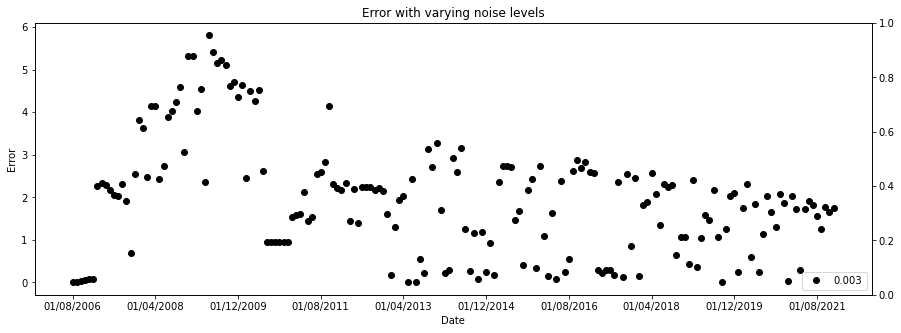

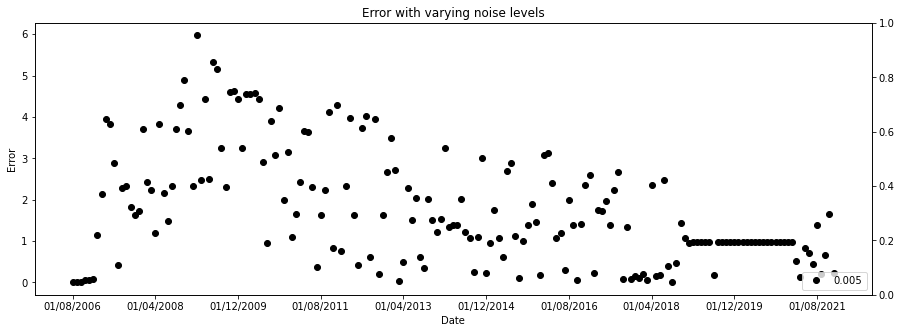

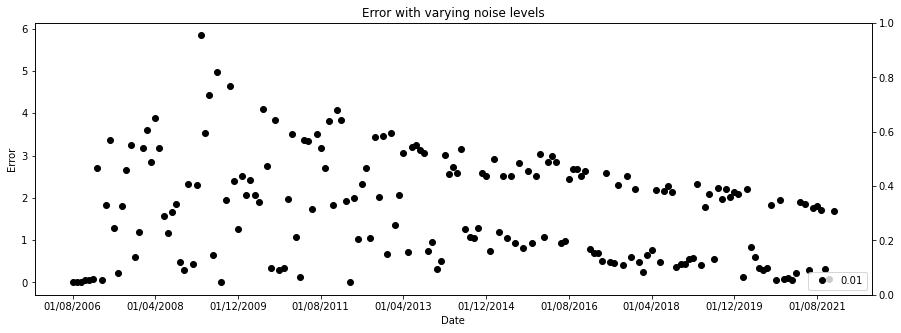

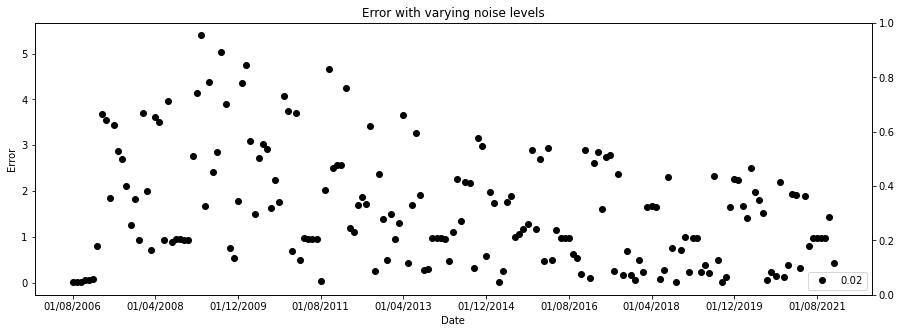

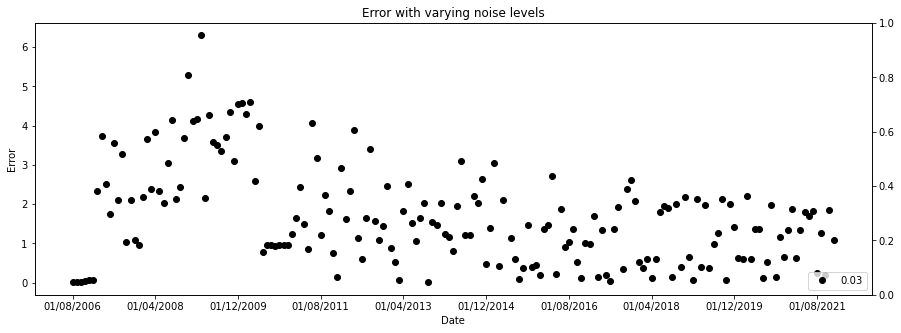

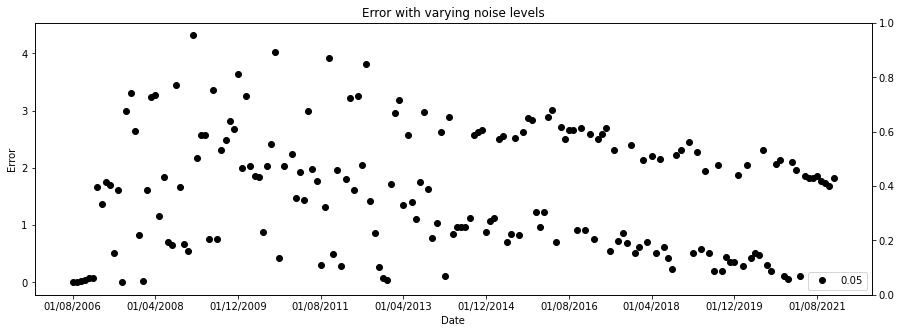

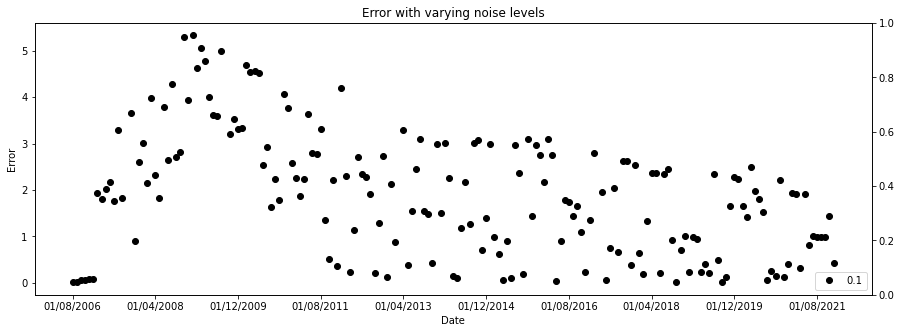

In [1164]:
error_res_all=prediction(3)
labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdDevs).T
display(df_error)
for i in range(len(stdDevs)):
    plt.figure(1, figsize=(15, 5))
    plt.plot(np.squeeze(date_test),error_res_all[i], color = 'black',lw = 1, label = stdDevs[i],marker = 'o',linestyle = 'None')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.title('Error with varying noise levels')
    plt.legend(loc="lower right")
    ax2=plt.twinx()
    ax2.set_xticks(ax2.get_xticks()[::20])
    plt.show()

#  Extra Credit

In [1571]:
pe=pd.read_csv('PERatios.csv')
data1 = pd.read_csv('SP500DATA.csv')

In [1572]:
pe=pe.rename({'Date':'Date_PE'},axis=1)
pe = pe[120:]
pe


,Date_PE,PE_CAPE
120,1970.01,17.090541
121,1970.02,16.372587
122,1970.03,16.531691
123,1970.04,15.873068
124,1970.05,13.983836
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [1573]:
data1['Date'] = pd.to_datetime(data1['Date'])


In [1574]:
spdata = data1[['Price','Open']].to_numpy(dtype = 'float')



In [1575]:
data1

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-01-12,4766.18,4623.80,4808.52,4494.20,-,0.0436
1,2021-01-11,4567.00,4616.47,4743.74,4560.26,-,-0.0083
2,2021-01-10,4605.38,4324.71,4608.70,4278.70,-,0.0691
3,2021-01-09,4307.54,4531.04,4544.58,4304.90,-,-0.0476
4,2021-01-08,4522.68,4415.90,4537.80,4369.20,-,0.0290
...,...,...,...,...,...,...,...
618,1970-01-06,72.72,76.55,79.96,72.25,-,-0.0500
619,1970-01-05,76.55,81.52,82.32,68.61,-,-0.0610
620,1970-01-04,81.52,89.63,90.70,79.31,-,-0.0905
621,1970-01-03,89.63,89.50,91.07,86.19,-,0.0015


In [1576]:
for i in range(data1.shape[0]):
    month = data1['Date'][i].day
    year = data1['Date'][i].year
    data1.loc[i, 'Date_PE']=year+month*0.01


In [1577]:
data_full = pd.merge(data1, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)

/var/folders/jt/kw0g2kss2753vbrcwqhj45sh0000gn/T/ipykernel_23436/839906278.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_full = data_full.drop(['Date_PE' ], 1)


In [1578]:
data_full

,Date,Price,Open,High,Low,Vol.,Change %,PE_CAPE
0,2021-01-12,4766.18,4623.80,4808.52,4494.20,-,0.0436,NaN
1,2021-01-11,4567.00,4616.47,4743.74,4560.26,-,-0.0083,NaN
2,2021-01-10,4605.38,4324.71,4608.70,4278.70,-,0.0691,NaN
3,2021-01-09,4307.54,4531.04,4544.58,4304.90,-,-0.0476,NaN
4,2021-01-08,4522.68,4415.90,4537.80,4369.20,-,0.0290,NaN
...,...,...,...,...,...,...,...,...
618,1970-01-06,72.72,76.55,79.96,72.25,-,-0.0500,13.799692
619,1970-01-05,76.55,81.52,82.32,68.61,-,-0.0610,13.983836
620,1970-01-04,81.52,89.63,90.70,79.31,-,-0.0905,15.873068
621,1970-01-03,89.63,89.50,91.07,86.19,-,0.0015,16.531691


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


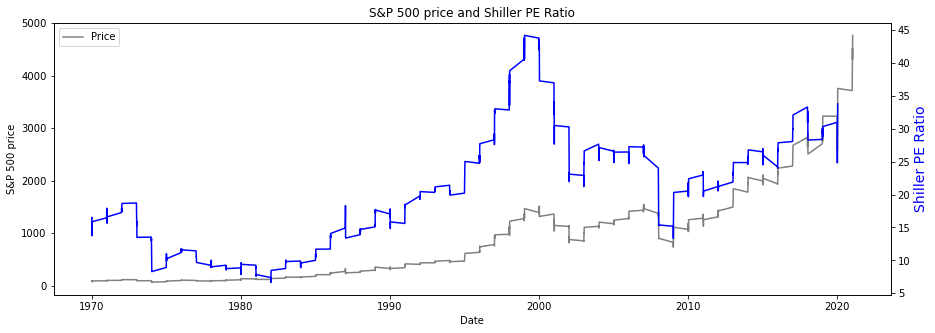

In [1579]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Price.values, color='grey', label='Price')

plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.savefig('price_pe.eps')
plt.show()

In [1725]:
data = data_full[ ['Price','PE_CAPE','Open']]
data['states'] = ""

/var/folders/jt/kw0g2kss2753vbrcwqhj45sh0000gn/T/ipykernel_23436/2832216036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['states'] = ""


In [1726]:
data = data[12:]


In [1771]:
data

,Price,PE_CAPE,Open,states,state
12,3756.07,33.769789,3645.87,,5
13,3621.63,32.471647,3296.20,,5
14,3269.96,31.277783,3385.87,,5
15,3363.00,30.833593,3507.44,,5
16,3500.31,31.152309,3288.26,,5
...,...,...,...,...,...
618,72.72,13.799692,76.55,,2
619,76.55,13.983836,81.52,,2
620,81.52,15.873068,89.63,,3
621,89.63,16.531691,89.50,,3


,Price,PE_CAPE,Open,states,state
12,3756.07,33.769789,3645.87,,5
13,3621.63,32.471647,3296.20,,5
14,3269.96,31.277783,3385.87,,5
15,3363.00,30.833593,3507.44,,5
16,3500.31,31.152309,3288.26,,5
...,...,...,...,...,...
618,72.72,13.799692,76.55,,2
619,76.55,13.983836,81.52,,2
620,81.52,15.873068,89.63,,3
621,89.63,16.531691,89.50,,3


In [1730]:
bins = [0,7.5,12.75,15,20,25,120]
labels=[0,1,2,3,4,5]
data['state'] = pd.cut(data['PE_CAPE'], bins=bins, labels=labels, include_lowest=True)
print(data)

data.drop('states',1)

       Price    PE_CAPE     Open states state
12   3756.07  33.769789  3645.87            5
13   3621.63  32.471647  3296.20            5
14   3269.96  31.277783  3385.87            5
15   3363.00  30.833593  3507.44            5
16   3500.31  31.152309  3288.26            5
..       ...        ...      ...    ...   ...
618    72.72  13.799692    76.55            2
619    76.55  13.983836    81.52            2
620    81.52  15.873068    89.63            3
621    89.63  16.531691    89.50            3
622    89.50  16.372587    85.02            3

[611 rows x 5 columns]


/var/folders/jt/kw0g2kss2753vbrcwqhj45sh0000gn/T/ipykernel_23436/1244713732.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop('states',1)


,Price,PE_CAPE,Open,state
12,3756.07,33.769789,3645.87,5
13,3621.63,32.471647,3296.20,5
14,3269.96,31.277783,3385.87,5
15,3363.00,30.833593,3507.44,5
16,3500.31,31.152309,3288.26,5
...,...,...,...,...
618,72.72,13.799692,76.55,2
619,76.55,13.983836,81.52,2
620,81.52,15.873068,89.63,3
621,89.63,16.531691,89.50,3


In [1731]:
dataset = data[['Price','Open','state']].values

In [1753]:
dataset

array([[1.        , 1.        , 1.        ],
       [0.96359136, 0.90239034, 1.        ],
       [0.86835313, 0.92742154, 1.        ],
       ...,
       [0.00486929, 0.00728297, 0.6       ],
       [0.00706562, 0.00724668, 0.6       ],
       [0.00703041, 0.0059961 , 0.6       ]])

In [1733]:
dataset= mmscaler.fit_transform(dataset)
dataset

array([[1.        , 1.        , 1.        ],
       [0.96359136, 0.90239034, 1.        ],
       [0.86835313, 0.92742154, 1.        ],
       ...,
       [0.00486929, 0.00728297, 0.6       ],
       [0.00706562, 0.00724668, 0.6       ],
       [0.00703041, 0.0059961 , 0.6       ]])

In [1735]:
n_rows, n_cols = dataset.shape
(n_rows,n_cols)

(611, 3)

In [1736]:
input_size = 3
output_size = 4
window_size = 6

In [1772]:
# Creating a data structure with 180 timesteps and 4 output
X = []
y = []
for i in range( n_rows - window_size - output_size +1):
    X.append(dataset[i:i+window_size, ])
    y.append(dataset[i+window_size: i+ window_size + output_size, 0])
    
X, y, date_full = np.array(X), np.array(y), np.array(date_full)
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))

In [1773]:
X_full.shape


(602, 6, 3)

In [1774]:
y_full.shape

(602, 1, 4)

In [1775]:
X.shape

(602, 6, 3)

In [1776]:
y.shape

(602, 1, 4)

In [1778]:
from sklearn.model_selection import train_test_split
X_full_train = []
X_train = []
X_validation = []
X_test = []
y_full_train = []
y_train = []
y_validation= []
y_test=[]

X_full_train, X_test, y_full_train, y_test,  = train_test_split(X,y,test_size = 0.3, shuffle = False)
X_train, X_validation, y_train, y_validation= train_test_split(X_full_train, y_full_train,test_size = 0.3, shuffle = False)
# date_test = date[438:623,:]

In [1779]:
import torch
import torch.nn as nn
from torch.autograd import Variable
class Model(nn.Module):
    def __init__(self, input_size, output_size,hidden_dim, n_layers):
        super(Model,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size,hidden_dim,n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out,hidden = self.rnn(x,hidden)
        out = self.fc(out)
        return out[:,-1,:], hidden
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers,batch_size,self.hidden_dim)
        return hidden

In [1780]:
X_train.shape

(294, 6, 3)

In [1781]:
y_test.shape

(181, 1, 4)

In [1786]:
RNN = Model(input_size = 3, output_size = 4, hidden_dim = 64, n_layers =2)
optimizer = torch.optim.Adam(RNN.parameters(), lr = 0.002)
criterion = nn.MSELoss()

In [1787]:
RNN

Model(
  (rnn): RNN(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [1788]:
xTensor = torch.from_numpy(X_full_train).float()
yTensor = torch.Tensor(y_full_train).float()
tot_loss = []
for epoch in range(100):
    
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    tot_loss +=[loss.item()]
    loss.backward()
    #add validation code
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}------'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100------ Loss: 0.1374758630990982
Epoch: 10/100------ Loss: 0.01961079239845276
Epoch: 20/100------ Loss: 0.0037548039108514786
Epoch: 30/100------ Loss: 0.0016251994529739022
Epoch: 40/100------ Loss: 0.001063598203472793
Epoch: 50/100------ Loss: 0.0007276547839865088
Epoch: 60/100------ Loss: 0.0006481694872491062
Epoch: 70/100------ Loss: 0.0005932808271609247
Epoch: 80/100------ Loss: 0.0005724596558138728
Epoch: 90/100------ Loss: 0.0005619973526336253


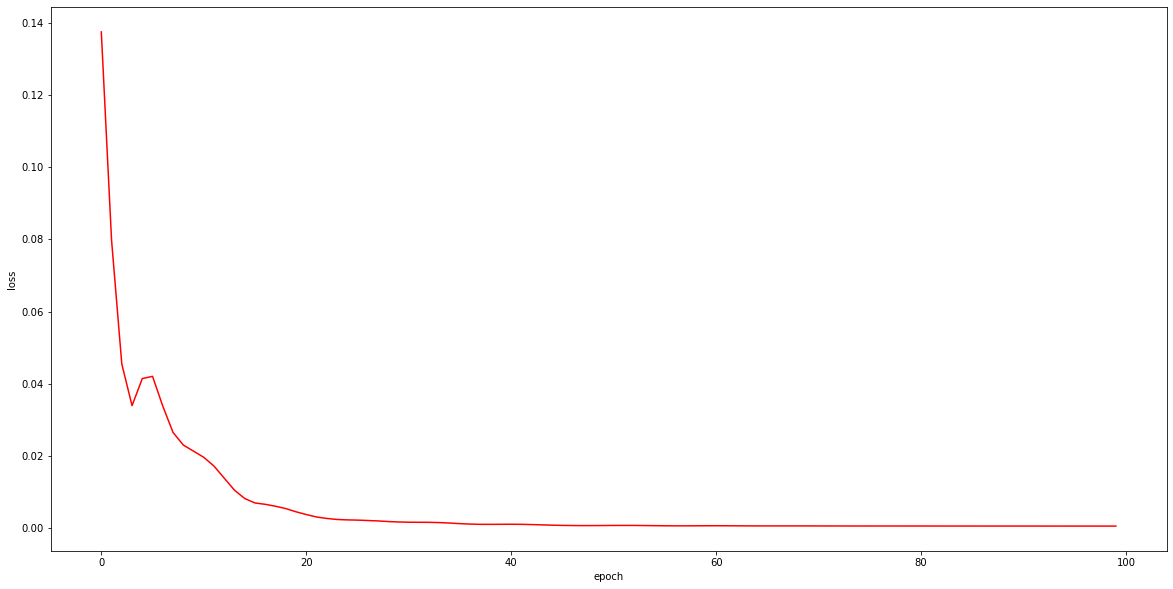

In [1789]:
plt.figure(figsize = [20,10])
plt.plot(np.array(tot_loss),'r',label = 'train')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [1805]:
output.shape

torch.Size([421, 4])